# First Year Project
## Project 1 - Road Collissions Analysis, ITU Copenhagen

This notebook contains all of the code developed for project 1, to explore the data set of Road Collisions from UK.gov with a focus on the city of Birmingham.

Nicola (niccl@itu.dk)<br>
Emma (@itu.dk)<br>
Karlis (@itu.dk)<br>
Kirstine (@itu.dk)<br>
Danielle (ddeq@itu.dk)<br>

Created: 12-02-2021
<br>Last modified: 12-02-2021

## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

## Functions

In [ ]:
def barplot(data, field_name, field_categories):
    """Make a bar plot of a categorical variable, given as a field field_name in the
    structured array data. Field categories and their names are given in the dict field_categories.
    """

    categories, counts = np.unique(data[field_name], return_counts=True)

    fig = plt.figure(figsize=(4, 3))
    axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)
    axes.bar(range(len(categories)), counts, fc= "coral") # fc is the face color

    axes.set_xlabel("")
    axes.set_ylabel('Count')
    axes.set_title(field_name)
    fig.autofmt_xdate(rotation=45)

    axes.set_xticks(range(len(categories)))
    axes.set_xticklabels([field_categories[c] for c in categories]);

## Constants

In [ ]:
PATH = {}
PATH["data_raw"] = "../Data/raw/"
PATH["data_interim"] = "../Data/interim/"
PATH["data_processed"] = "../Data/processed/"
PATH["data_external"] = "../Data/external/"

FILENAME = {}
FILENAME["accidents"] = "Road Safety Data - Accidents 2019.csv"
FILENAME["casualties"] = "Road Safety Data - Casualties 2019.csv"
FILENAME["vehicles"] = "Road Safety Data- Vehicles 2019.csv" 

TABLENAMES = ["accidents", "casualties", "vehicles"]

## Load raw data

The data were downloaded from here on Jan 4th: https://data.gov.uk/dataset/road-accidents-safety-data
That page was updated afterwards (Jan 8th), so local and online data may be inconsistent.

In [ ]:
dataraw = {}
dataraw["accidents"] = np.genfromtxt(PATH["data_raw"]+FILENAME["accidents"], delimiter=',', dtype=None, names=True, encoding='utf-8-sig')
dataraw["vehicles"] = np.genfromtxt(PATH["data_raw"]+FILENAME["vehicles"], delimiter=',', dtype=None, names=True, encoding='utf-8-sig')
dataraw["casualties"] = np.genfromtxt(PATH["data_raw"]+FILENAME["casualties"], delimiter=',', dtype=None, names=True, encoding='utf-8-sig')

In [ ]:
# Get a dictionary of the variable names for each table
variable_names_raw = {}
for variable_name in TABLENAMES:
    variable_names_raw[variable_name] = list(dataraw[variable_name].dtype.names)

In [ ]:
#variable_names_raw["accidents"]

In [ ]:
#dataraw["accidents"][:5]

## Report the dimensions of the data (number of tables, rows, fields).

We have 3 tables: Accidents, Casualites, and Vehicles data tables.

### Number of records in each table

In [ ]:
print(f"Number of records in accident table: {dataraw['accidents'].shape}")
print(f"Number of records in vehicles table: {dataraw['vehicles'].shape}")
print(f"Number of records in casualties table: {dataraw['casualties'].shape}")

### Number of fields in each table

In [ ]:
print(f"Number of fields in the accident table: {len(dataraw['accidents'].dtype)}")
print(f"Number of fields in the vehicles table: {len(dataraw['vehicles'].dtype)}")
print(f"Number of fields in the casualties table: {len(dataraw['casualties'].dtype)}")

In [ ]:
#dataraw["accidents"]["Local_Authority_District"]

### Checking IDs

In [ ]:
raw_accident_AI=dataraw["accidents"]["Accident_Index"]
raw_vehicles_AI=dataraw["vehicles"]["Accident_Index"]
raw_casualties_AI=dataraw["casualties"]["Accident_Index"]
#print(#memeber of raw_vehicles_ids and not raw_acidents_its)
mask_missing_c_AI = np.where(np.isin(dataraw["casualties"]["Accident_Index"], (raw_accident_AI)))
print("Number of accident IDs in the casualties data:",len(raw_casualties_AI),"\nNumber of IDs in the casualties data tha also appear in the accidents data:",len(raw_casualties_AI[mask_missing_c_AI]))
mask_missing_v_AI = np.where(np.isin(dataraw["vehicles"]["Accident_Index"], (raw_accident_AI)))
print("Number of accident IDs in the vehicles data:",len(raw_vehicles_AI),
      "\nNumber of IDs in the cvehicles data tha also appear in the accidents data:",
      len(raw_vehicles_AI[mask_missing_v_AI]))

### Does every AccidentID in the casualties and vehicles tables have their corresponding AccidentID in the accident table?

Yes, after cleaning both the casualties and vehicles sheets to only have records where their accident ID is in the cleaned Birmingham accident sheet.

### Does every entry in the Accidents table reference the correct amount of entries in the vehicles and casualties tables?

In [ ]:
#dictionary of nummber of entries in vehicles
num_vehicles_for_id={}
num_casualties_for_id={}
#initialise
for i in dataraw["accidents"]:
    num_vehicles_for_id[i["Accident_Index"]]=0
    num_casualties_for_id[i["Accident_Index"]]=0
#find number of entries 
for i in dataraw["vehicles"]:
    num_vehicles_for_id[i["Accident_Index"]]+=1
for i in dataraw["casualties"]:
    num_casualties_for_id[i["Accident_Index"]]+=1


In [ ]:
#check if the same as in accidents
for i in dataraw["accidents"]:
    if i["Number_of_Vehicles"]!=num_vehicles_for_id[i["Accident_Index"]]:
        print("There are mis-matching numbers of records i nvehicles data")
for i in dataraw["accidents"]:
    if i["Number_of_Casualties"]!=num_casualties_for_id[i["Accident_Index"]]:
        print("There are mis-matching numbers of records in casualties data")

Hence we can say that the accidents table references the correct amount of entries in the vehicles and casualties tables

## Masking for Birmingham

Birmingham is listed as code "300" under the "Local_Authority_District" field. First we narrowed down the accidents table to only show records that match this code in that field.

In [ ]:
# Create a dictionary to hold all of the clean data
data_bir = {}

# creating the mask to show the data for Birmingham on the accidents sheet
birmingham_mask = np.where(dataraw["accidents"]["Local_Authority_District"] == 300)
data_bir["accidents"] = dataraw["accidents"][birmingham_mask]

Then we narrowed down the casualties and vehicles sheets to only have records that would be reflected in the accident sheet, thereby having only records of that pertain to Birmingham.

In [ ]:
# Create an array of the accident IDs related to Birmingham (use this to filter the other tables)
accident_ids = np.array(data_bir["accidents"]["Accident_Index"])

# Create a mask to filter casualties table based on the accident ids
casualties_mask = np.where(np.isin(dataraw["casualties"]["Accident_Index"], (accident_ids)))
data_bir["casualties"] = dataraw["casualties"][casualties_mask]

In [ ]:
# Create a mask to filter vehicles table based on the accident ids
vehicles_mask = np.where(np.isin(dataraw["vehicles"]["Accident_Index"], (accident_ids)))
data_bir["vehicles"] = dataraw["vehicles"][vehicles_mask]

In [ ]:
# An example of how we would save a copy of the processed data to the correct directory
#clean_accidents.to_csv(r'../Data/interim/clean_accidents.csv', index = False, header = True)
#np.savetxt(PATH["data_interim"] + "clean_accidents.csv", clean_accidents, delimiter=",")

## Identify for each variable whether it is numerical or categorical.

### Insight: Mixed variable types

Accidents have mixed data types, including strings, floats, and integers. Categorical variables are encoded as integers. The meaning of these categories can be looked up in: ../references/variable lookup.xls

In [ ]:
# Number of entries in each table after being filtered to Birmingham

print(f"Number of records in Birmingham accident table: {data_bir['accidents'].shape}")
print(f"Number of records in Birmingham casualties table: {data_bir['casualties'].shape}")
print(f"Number of records in Birmingham vehicles table: {data_bir['vehicles'].shape}")

We manually went through the variable lists to come up with which variables were categorical or numerical.

References<br>
what is categorical - http://www.stat.yale.edu/Courses/1997-98/101/catdat.htm <br>
the hell is LSOA - https://datadictionary.nhs.uk/nhs_business_definitions/lower_layer_super_output_area.html#:~:text=A%20Lower%20Layer%20Super%20Output,Lower%20Layer%20Super%20Output%20Areas
decile -http://mast.roadsafetyanalysis.org/wiki/index.php?title=Driver_IMD_Decile#:~:text=An%20IMD%20decile%20is%20a,the%2010%25%20least%20deprived%20areas.


Acidents <br><br>
Accident_Index  - Categorical<br>
Location_Easting_OSGR  - Numerical<br>
Location_Northing_OSGR  - Numerical<br>
Longitude  - Numerical<br>
Latitude  - Numerical<br>
Police_Force  - Categorical<br>
Accident_Severity  - Categorical<br>
Number_of_Vehicles  - Numerical<br>
Number_of_Casualties  - Numerical<br>
Date  - Numerical/Categorical<br>
Day_of_Week  - Categorical<br>
Time  - Numerical(but can be categorical)<br>
Local_Authority_(District)  - Categorical<br>
Local_Authority_(Highway)  - Categorical<br>
1st_Road_Class  - Categorical<br>
1st_Road_Number  - Categorical<br>
Road_Type  - Categorical<br>
Speed_limit  - Categorical(we questioned this)<br>
Junction_Detail  - Categorical<br>
Junction_Control  - Categorical<br>
2nd_Road_Class  - Categorical<br>
2nd_Road_Number  - Categorical<br>
Pedestrian_Crossing-Human_Control  - Categorical<br>
Pedestrian_Crossing-Physical_Facilities  - Categorical<br>
Light_Conditions  - Categorical<br>
Weather_Conditions  - Categorical<br>
Road_Surface_Conditions  - Categorical<br>
Special_Conditions_at_Site  - Categorical<br>
Carriageway_Hazards  - Categorical<br>
Urban_or_Rural_Area  - Categorical<br>
Did_Police_Officer_Attend_Scene_of_Accident  - Categorical<br>
LSOA_of_Accident_Location  - Categorical<br>

Vehicles<br><br>
Accident_Index  - Categorical<br>
Vehicle_Reference  - Categorical<br>
Vehicle_Type  - Categorical<br>
Towing_and_Articulation  - Categorical<br>
Vehicle_Manoeuvre  - Categorical<br>
Vehicle_Location-Restricted_Lane  - Categorical<br>
Junction_Location  - Categorical<br>
Skidding_and_Overturning  - Categorical<br>
Hit_Object_in_Carriageway  - Categorical<br>
Vehicle_Leaving_Carriageway  - Categorical<br>
Hit_Object_off_Carriageway  - Categorical<br>
1st_Point_of_Impact  - Categorical<br>
Was_Vehicle_Left_Hand_Drive?  - Categorical<br>
Journey_Purpose_of_Driver  - Categorical<br>
Sex_of_Driver  - Categorical<br>
Age_of_Driver  - Numerical<br>
Age_Band_of_Driver  - Categorical<br>
Engine_Capacity_(CC)  - Numerical<br>
Propulsion_Code  - Categorical(probably)<br>
Age_of_Vehicle  - Numerical<br>
Driver_IMD_Decile  - Categorical<br>
Driver_Home_Area_Type  - Categorical<br>
Vehicle_IMD_Decile  - Categorical<br>

Casualties <br><br>
Accident_Index  - Categorical<br>
Vehicle_Reference  - Categorical<br>
Casualty_Reference  - Categorical<br>
Casualty_Class  - Categorical<br>
Sex_of_Casualty  - Categorical<br>
Age_of_Casualty  - Numerical<br>
Age_Band_of_Casualty  - Categorical<br>
Casualty_Severity  - Categorical<br>
Pedestrian_Location  - Categorical<br>
Pedestrian_Movement  - Categorical<br>
Car_Passenger  - Categorical<br>
Bus_or_Coach_Passenger  - Categorical<br>
Pedestrian_Road_Maintenance_Worker  - Categorical<br>
Casualty_Type  - Categorical<br>
Casualty_Home_Area_Type  - Categorical<br>
Casualty_IMD_Decile  - Categorical<br>

# Dealing with missing data

### First we will go through missing data from the unfiltered data for all of UK

In [ ]:
dataraw_masked = {}
for variable_name in TABLENAMES:
    dataraw_masked[variable_name] = np.genfromtxt(PATH["data_raw"] + FILENAME[variable_name], delimiter = ',', dtype = None, names = True, encoding='utf-8-sig', usemask = True)

In [ ]:
print(f"Number of rows with missing values: {np.count_nonzero(dataraw_masked['accidents'].mask)}")

In [ ]:
print(f"Percentage of rows with missing values: {round(5776/117536, 2)}%")

In [ ]:
# Rows where data is missing
row_incomplete = np.where(dataraw_masked["accidents"].mask)[0]

In [ ]:
missingpositions = {}
missingvalues = 0
missingconfigurations = set()
for rowpos in row_incomplete:
    missingpositions_thisrow = list(np.where(list(dataraw_masked["accidents"].mask[rowpos]))[0])
    missingpositions[rowpos] = missingpositions_thisrow
    missingvalues += len(missingpositions_thisrow)
    missingconfigurations.add(tuple(missingpositions_thisrow))
    
missingfieldnames = [np.array(variable_names_raw["accidents"])[c] for c in [list(b) for b in missingconfigurations]]

In [ ]:
print("Incomplete rows: " + str(np.count_nonzero(dataraw_masked["accidents"].mask)))
print("Missing values: " + str(missingvalues))

print("\nMissing field configurations: " + str(missingconfigurations))
for i in missingfieldnames:
    print(i)

### Then, we will repeat the same steps with the tables that only contain records of Birmingham.

In [ ]:
# Create a dictionary for the clean, masked data
data_bir_masked = {}

# creating the mask to show the data for Birmingham on the accidents sheet
birmingham_mask2 = np.where(dataraw_masked["accidents"]["Local_Authority_District"] == 300)
data_bir_masked["accidents"] = dataraw_masked["accidents"][birmingham_mask2]

In [ ]:
# Create an array of the accident IDs related to Birmingham (use this to filter the other tables)
accident_ids2 = np.array(data_bir_masked["accidents"]["Accident_Index"])

# Create a mask to filter casualties table based on the accident ids
casualties_mask2 = np.where(np.isin(dataraw_masked["casualties"]["Accident_Index"], (accident_ids2)))
data_bir_masked["casualties"] = dataraw_masked["casualties"][casualties_mask2]

In [ ]:
# Create a mask to filter vehicles table based on the accident ids
vehicles_mask2 = np.where(np.isin(dataraw_masked["vehicles"]["Accident_Index"], (accident_ids2)))
data_bir_masked["vehicles"] = dataraw_masked["vehicles"][vehicles_mask2]

In [ ]:
print(f"Number of rows with missing values: {np.count_nonzero(data_bir_masked['accidents'].mask)}")
print(f"Number of rows with missing values: {np.count_nonzero(data_bir_masked['casualties'].mask)}")
print(f"Number of rows with missing values: {np.count_nonzero(data_bir_masked['vehicles'].mask)}")

It seems there are no records in our narrowed down data set that have missing values.

## Checking for Missing Values
What we need to check for:
- making sure that values for missing values can't be interpreted as real values
<br>especially for numerical values as missing values stored as 999999 for example may affect calculations
- counts of missing values in each column
we dont think doing this would be usefull. 
But if needed in futrue the njust make a mask of the data where the values are "missing values" and find length

### Numerical Variables 
The missing values represented as:<br>
(Looked up in Excel)
<br>

#### Note: all the following points are in regard to ALL the data and not just the Birmingham Data

**Accidents** <br><br>
Location_Easting_OSGR  - Null (No values missing)<br>
Location_Northing_OSGR  - Null <br>
Longitude  - Null<br>
Latitude  - Null<br>
Number_of_Vehicles  - values from 1-17 none missing  <br>
Number_of_Casualties  - values from 1-52 -  none missing<br>
<br>
**Vehicles**<br><br>
Age_of_Driver  - 1-102 missing is -1 (we should change this or at least be aware of this if we want to do any numerical analysis) the one year old was driving an unidentified vehicle and was not hurt<br>
Engine_Capacity_(CC)  - 1-29980 missing values -1  (we should change this or at least be aware of this if we want to do any numerical analysis)<br>
Age_of_Vehicle  - 1-94 missing vaules are -1 (we should change this or at least be aware of this if we want to do any numerical analysis)<br>
<br>
**Casualties**<br><br>
Age_of_Casualty  - -1 (we should change this or at least be aware of this if we want to do any numerical analysis)
<br>

In [ ]:
# Cleaning the Age_of_Driver to account for negative numbers
age_cleaning_mask = np.where(data_bir["vehicles"]["Age_of_Driver"] > 0)
clean_AOD_accidents = data_bir["vehicles"][age_cleaning_mask]

In [ ]:
# Cleaning the Engine_Capacity_CC for negative numbers
EC_cleaning_mask = np.where(data_bir["vehicles"]["Engine_Capacity_CC"] > 0)
clean_EC_vehicles = data_bir["vehicles"][EC_cleaning_mask]

In [ ]:
# Cleaning the Age_of_Vehicle for negative numbers
AOV_cleaning_mask = np.where(data_bir["vehicles"]["Age_of_Vehicle"] > 0)
clean_AOV_vehicles = data_bir["vehicles"][AOV_cleaning_mask]

In [ ]:
# Cleaning the Age_of_Casualty for negative numbers
AOC_cleaning_mask = np.where(data_bir["casualties"]["Age_of_Casualty"] > 0)
clean_AOC_casualties = data_bir["casualties"][AOC_cleaning_mask]

## Five number summarys for all numerical variables, Box Plots, Frequency Histograms

### Number of vehicles

In [ ]:
number_of_vehicles = sorted(data_bir["accidents"]["Number_of_Vehicles"])

quartiles_NOV = np.percentile(number_of_vehicles, [25, 50, 75])
#print(number_of_vehicles)

# calculate min/max
data_min_NOV, data_max_NOV = min(number_of_vehicles), max(number_of_vehicles)

# print 5-number summary
print('Min: %.3f' % data_min_NOV)
print('Q1: %.3f' % quartiles_NOV[0])
print('Median: %.3f' % quartiles_NOV[1])
print('Q3: %.3f' % quartiles_NOV[2])
print('Max: %.3f' % data_max_NOV)
#print(number_of_vehicles)

In [ ]:
#Histogram and Boxplot for number_of_vehicles 
fig = plt.figure(figsize=(5,5));
fig, (ax1, ax2) = plt.subplots(2, 1);
ax1.hist(number_of_vehicles, 10);
ax2.boxplot(number_of_vehicles, showfliers= True, vert=False, whis = [0,100]);

ax1.set_xlabel('Number of vehicles in an accident');
ax1.set_ylabel('Cumilative Frequency of vehicles');


ax2.set_xlabel('Number of vehicles in an accident');

fig.suptitle('Vehicles');

### Number of Casualties

In [ ]:
# Number_of_Casualties - Numerical
number_of_casualties = sorted(data_bir["accidents"]["Number_of_Casualties"])
quartiles_NOC = np.percentile(number_of_casualties, [25, 50, 75])

# calculate min/max
data_min_NOC, data_max_NOC = min(number_of_casualties), max(number_of_casualties)

# print 5-number summary
print('Min: %.3f' % data_min_NOC)
print('Q1: %.3f' % quartiles_NOC[0])
print('Median: %.3f' % quartiles_NOC[1])
print('Q3: %.3f' % quartiles_NOC[2])
print('Max: %.3f' % data_max_NOC)

In [ ]:
#Histogram and Boxplot for number_of_casualties 
fig = plt.figure(figsize=(5,5));
fig, (ax1, ax2) = plt.subplots(2, 1);
ax1.hist(number_of_casualties, 10);
ax2.boxplot(number_of_casualties, showfliers= True, vert=False, whis = [0, 100]);

ax1.set_xlabel('Number of Casualties per accident');
ax1.set_ylabel('Cumilative Frequency of casualties');


ax2.set_xlabel('Number of Casualties per accident');

fig.suptitle('Casualties');
                      

### Age of Driver

In [ ]:
# Age_of_Driver - Numerical
age_of_driver = sorted(clean_AOD_accidents["Age_of_Driver"])
quartiles_AOD = np.percentile(age_of_driver, [25, 50, 75])

# calculate min/max
data_min_AOD, data_max_AOD = min(age_of_driver), max(age_of_driver)

# print 5-number summary
print('Min: %.3f' % data_min_AOD)
print('Q1: %.3f' % quartiles_AOD[0])
print('Median: %.3f' % quartiles_AOD[1])
print('Q3: %.3f' % quartiles_AOD[2])
print('Max: %.3f' % data_max_AOD)

In [ ]:
#Histogram and Boxplot for age_of_driver
fig = plt.figure(figsize=(5,5));
fig, (ax1, ax2) = plt.subplots(2, 1);
ax1.hist(age_of_driver, 10);
ax2.boxplot(age_of_driver, showfliers= False, vert=False, whis = [0,100]);

ax1.set_xlabel('Age');
ax1.set_ylabel('Cumilative frquency of Age');


ax2.set_xlabel('Age');

fig.suptitle('Age of drivers');

### Engine Capacity

In [ ]:
# Engine_Capacity_(CC) - Numerical 

#using the data from clean_EC_vehicles

engine_capacity = sorted(clean_EC_vehicles["Engine_Capacity_CC"])
quartiles_EC = np.percentile(engine_capacity, [25, 50, 75])

# calculate min/max
data_min_EC, data_max_EC = min(engine_capacity), max(engine_capacity)

# print 5-number summary
print('Min: %.3f' % data_min_EC)
print('Q1: %.3f' % quartiles_EC[0])
print('Median: %.3f' % quartiles_EC[1])
print('Q3: %.3f' % quartiles_EC[2])
print('Max: %.3f' % data_max_EC)

In [ ]:
#Histogram and Boxplot for engine_capacity
fig = plt.figure(figsize=(5,5));
fig, (ax1, ax2) = plt.subplots(2, 1);
ax1.hist(engine_capacity, 10);
ax2.boxplot(engine_capacity, showfliers= False, vert=False, whis= [0,100]);

ax1.set_xlabel('Engine capacity');
ax1.set_ylabel('Cumilative frequency of engine capacity');

ax2.set_xlabel('Engine capacity ');

fig.suptitle('Engine capacity');

### Age of Vehicle

In [ ]:
# Age_of_Vehicle - Numerical

#using the data from clean_AOV_vehicles

age_of_vehicle = sorted(clean_AOV_vehicles["Age_of_Vehicle"])
quartiles_AOV = np.percentile(age_of_vehicle, [25, 50, 75])

# calculate min/max
data_min_AOV, data_max_AOV = min(age_of_vehicle), max(age_of_vehicle)

# print 5-number summary
print('Min: %.3f' % data_min_AOV)
print('Q1: %.3f' % quartiles_AOV[0])
print('Median: %.3f' % quartiles_AOV[1])
print('Q3: %.3f' % quartiles_AOV[2])
print('Max: %.3f' % data_max_AOV)

In [ ]:
#Histogram and Boxplot for age_of_vehicle
fig = plt.figure(figsize=(5,5));
fig, (ax1, ax2) = plt.subplots(2, 1);
ax1.hist(age_of_vehicle, 10);
ax2.boxplot(age_of_vehicle, showfliers= False, vert=False, whis= [0,100]);

ax1.set_xlabel('Age of vehicle');
ax1.set_ylabel('Cumilative frquency of the age of vehicles');

ax2.set_xlabel('Age of vehicle');

fig.suptitle('Graphs for the age of vehicle');

### Age of Casualty

In [ ]:
# Age_of_Casualty - Numerical

# using the data from clean_AOC_casualties

age_of_casualty = sorted(clean_AOC_casualties["Age_of_Casualty"])
quartiles_AOC = np.percentile(age_of_casualty, [25, 50, 75])

# calculate min/max
data_min_AOC, data_max_AOC = min(age_of_casualty), max(age_of_casualty)

# print 5-number summary
print('Min: %.3f' % data_min_AOC)
print('Q1: %.3f' % quartiles_AOC[0])
print('Median: %.3f' % quartiles_AOC[1])
print('Q3: %.3f' % quartiles_AOC[2])
print('Max: %.3f' % data_max_AOC)

In [ ]:
#Histogram and Boxplot for age_of_casualty
fig = plt.figure(figsize=(5,5));
fig, (ax1, ax2) = plt.subplots(2, 1);
ax1.hist(age_of_casualty, 10);
ax2.boxplot(age_of_casualty, showfliers= False, vert=False, whis=[0,100]);

ax1.set_xlabel('Age of Casualty');
ax1.set_ylabel('Cumilative Frequency of age of Casualty');


ax2.set_xlabel('Age of Casualty');

fig.suptitle('Graphs for the Age of Casualties');

### Categorical barplots for Single Variable Analysis
#### Also comparing Birmingham to the whole UK

#### Comparing Sex of Driver for Birmingham and the UK

In [ ]:
field_name = "Sex_of_Driver"
field_categories = {1: "Male", 2: "Female", 3: "Not Known", -1: "Data missing or out of range"}

ax1 = barplot(data_bir["vehicles"], field_name, field_categories)
ax2 =barplot(dataraw["vehicles"], field_name, field_categories)

In [ ]:
#variable_names_raw["accidents"]

#### Vehicle type counts for Birmingham and the UK

In [ ]:
field_name = "Vehicle_Type"
field_categories = {1: "Pedal cycle", 2: "Motorcycle 50cc and under", 3: "Motorcycle 125cc and under", 
                    4: "Motorcycle over 125cc and up to 500cc", 5: "Motorcycle over 500cc",
                   8: "Taxi/Private hire car", 9: "Car", 10 : "Minibus (8 - 16 passenger seats)",
                   11: "Bus or coach (17 or more pass seats)", 16: "Ridden horse", 17: "Agricultural vehicle",
                   18: "Tram", 19: "Van / Goods 3.5 tonnes mgw or under", 20: "Goods over 3.5t. and under 7.5t",
                   21: "Goods 7.5 tonnes mgw and over", 22: "Mobility scooter", 23: "Electric motorcycle",
                   90: "Other vehicle", 97: "Motorcycle - unknown cc", 98: "Goods vehicle - unknown weight",
                   -1: "Data missing or out of range"}

ax1 = barplot(data_bir["vehicles"], field_name, field_categories)
ax2 =barplot(dataraw["vehicles"], field_name, field_categories)

We had thought that Birmingham would have more bus accidents, but we see that the majority are quite largely cars.

#### Comparing road types in Birmingham and the UK

In [ ]:
field_name = "Road_Type"
field_categories = {1: "Roundabout", 2: "One way street", 3: "Dual carriageway", 
                   6: "Single carriageway", 7: "Slip road", 9 : "Unknown",
                   12: "One way street/Slip road", -1: "Data missing or out of range"}

ax1 = barplot(data_bir["accidents"], field_name, field_categories)
ax2 =barplot(dataraw["accidents"], field_name, field_categories)

#### Comparing Accident Times of Day

In [ ]:
field_name = "Time"
time_categories = {"00": "0:00-01:00", "01": "01:00-02:00", "02": "02:00-03:00", "03": "03:00-04:00",
                    "04": "04:00-05:00", "05": "05:00-06:00", "06": "06:00-07:00", "07": "07:00-08:00",
                   "08": "08:00-09:00", "09": "09:00-10:00", "10": "10:00-11:00", "11": "11:00-12:00",
                   "12": "12:00-13:00", "13": "13:00-14:00", "14": "14:00-15:00", "15": "15:00-16:00",
                   "16": "16:00-17:00", "17": "17:00-18:00", "18": "18:00-19:00", "19": "19:00-20:00",
                   "20": "20:00-21:00", "21": "21:00-22:00","22": "22:00-23:00", "23": "23:00-24:00"}

plt.bar()
categories, counts = np.unique(data[field_name], return_counts=True)

In [ ]:
#data_bir["accidents"]["Time"][1][:2]

In [ ]:
# Make a count of the accidents at each time in Birmingham
times_dic_count = {}
for time_category in time_categories:
    times_dic_count[time_category] = 0
for i in range(len(data_bir["accidents"]["Time"])):
    times_dic_count[data_bir["accidents"]["Time"][i][:2]] += 1
#times_dic_count

# Make a count of the accidents at each time in the UK
times_dic_count_uk = {}
for time_category in time_categories:
    times_dic_count_uk[time_category] = 0
times_dic_count_uk[''] = 0
for i in range(len(dataraw["accidents"]["Time"])):
    times_dic_count_uk[dataraw["accidents"]["Time"][i][:2]] += 1
#times_dic_count_uk

In [ ]:
fig = plt.figure(figsize=(20,20));
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,15));
fig.autofmt_xdate(rotation=45)

ax1.bar(times_dic_count.keys(), times_dic_count.values(), fc="purple")
ax2.bar(times_dic_count_uk.keys(), times_dic_count_uk.values(), fc="purple")
ax1.set_title("Accident Times in Birmingham")
ax2.set_title("Accident Times in the whole UK")

In Birmingham, between 10:00 til 14:00 there are less accidents than the rest of the UK, but between 18:00-20:00 there are more.

# Task 2: Associations
Research whether there is a significant statistical association in your city, either 
- between some vehicle attributes and accident circumstances
- between some casualty attributes and accident circumstances

Report whether there is a statistically significant association between such variables or not, together with the appropriate statistical metric(s). Discuss why this association, or the lack of this association, is relevant for urban/transport planning.

## Association test between two categorical variables
###### (Pearson $\chi^2$ test of independence)

Inspired by:
https://peterstatistics.com/CrashCourse/3-TwoVarUnpair/NomNom/NomNom-2a-Test.html
https://bit.ly/3kbwKEL

### Hypothesis testing
We are now in the realm of Statistical hypothesis testing (https://en.wikipedia.org/wiki/Statistical_hypothesis_testing). In general, we must first state and compare two hypotheses:

- $H_0$ (null hypothesis): There is no statistically significant relationship between accident severity and speed limit.
- $H_\alpha$ (alternative hypothesis): There is a statistically significant relationship between accident severity and speed limit.

We must then 1) state+check statistical assumptions, 2) choose an appropriate test and test statistic $T$, 3) derive the distribution for the test statistic, 4) select a significance level $\alpha$, usually 0.01 or 0.05, 5) calculate the observed test statistic $t_{\mathrm obs}$, 6) calculate the p-value.

If the p-value $&lt; \alpha$, then the null hypothesis will be rejected.



#### Pearson $\chi^2$ test of independence
To test association between two categorical variables, one uses the Pearson chi-square test of independence. If the significance of this test (p-value) is below a significance level (typically 0.05), the two variables have a significant association.

The Pearson chi-square test should only be used if most cells have an expected count above 5, and the minimum expected count is at least 1.

### Question: Is there a statistical association between Age of Driver and Accident Severity? This did not work because the two variables are from two different excel sheets and therefore have different sizes of data
We ask this question because maybe the mayor of government can restrict the age of driver to a certain age, whether that be because old people are more dangerous drivers or young people are.

In [ ]:
#mask = (data_bir["vehicles"]["Age_of_Driver"] != -1)
#age_vs_severity = np.array(clean_AOD_accidents, data_bir["accidents"]["Accident_Severity"][mask]).T
#print(age_vs_severity.shape)
#print(age_vs_severity)

print(clean_AOD_accidents.shape)
print((data_bir["accidents"]["Accident_Severity"]).shape)

I tried to put both variables into a np.array but since they are not the same size it does not work... am now researching a way to solve this.

There are more data points in the vehicles sheet (3465) - looking at age of driver compared to the accidents sheet which only has 2623 data points.

Idea to solve this: make vehicles with the same ID into one data point... but sounds like that would take freaking forever...

new thought: idea would not work because for example one accident has 2 vehicles with 2 different ages of drivers

a new question to look at (in the same excel sheet)
### New Question: Is there a statistical association between Road Conditions and Accident Severity?

In [ ]:
mask = (data_bir["accidents"]["Road_Surface_Conditions"] != -1)
road_surface_severity = np.array([data_bir["accidents"]["Road_Surface_Conditions"][mask], data_bir["accidents"]["Accident_Severity"][mask]]).T
print(road_surface_severity.shape)
print(road_surface_severity)

###### Crosstab
We crosstabulate using pandas: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html

The cross tabulation is also known as contingency table.

In [ ]:
observed_pd = pd.crosstab(road_surface_severity[:, 0], road_surface_severity[:, 1], rownames = ["Road Surface Conditions"], colnames = ["Accident Severity"]) 
observed = observed_pd.to_numpy()
observed_pd

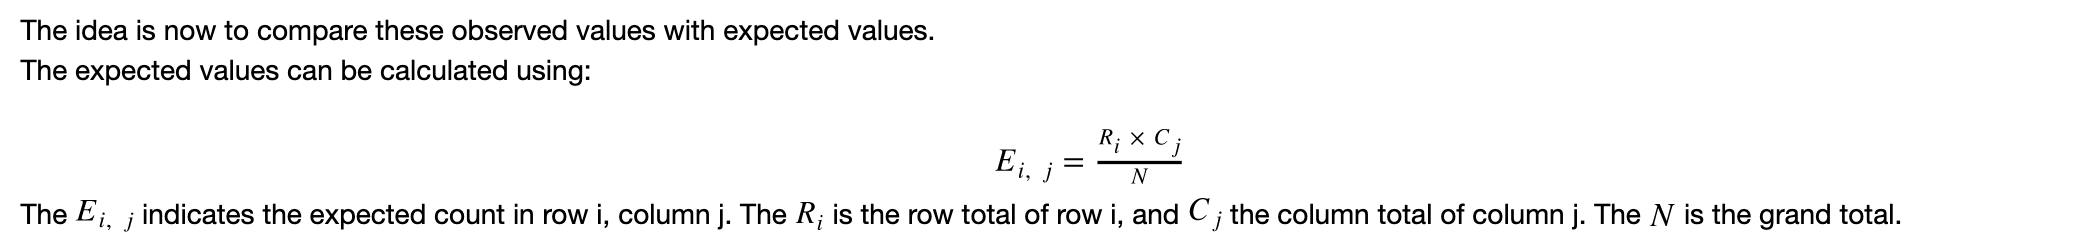